# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [44]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [45]:
%pip install pmdarima
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [47]:
path = 'Traffic Data.csv'
df = pd.read_csv(path, parse_dates=['date_time'])

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [49]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [50]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,date_time
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000,20000
mean,3278.186887,281.162680,0.048396,0.0,49.384600,2017-10-22 04:13:17.939999744
min,113.000000,243.390000,0.000000,0.0,0.000000,2016-11-18 15:00:00
25%,1228.750000,271.950000,0.000000,0.0,1.000000,2017-04-30 14:45:00
50%,3430.000000,281.825000,0.000000,0.0,75.000000,2017-10-21 07:30:00
75%,4928.000000,291.840000,0.000000,0.0,90.000000,2018-04-13 21:00:00
max,16781.000000,310.070000,10.600000,0.0,92.000000,2018-09-30 23:00:00
std,1977.171357,12.661288,0.398007,0.0,39.647341,NaN


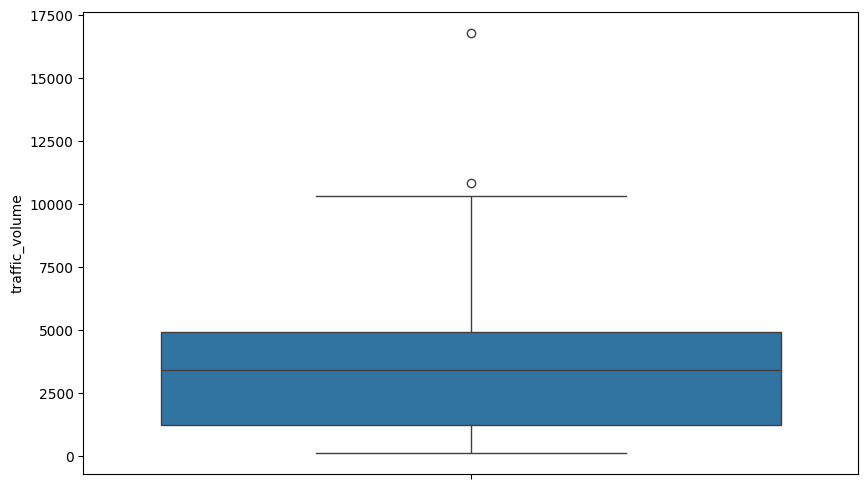

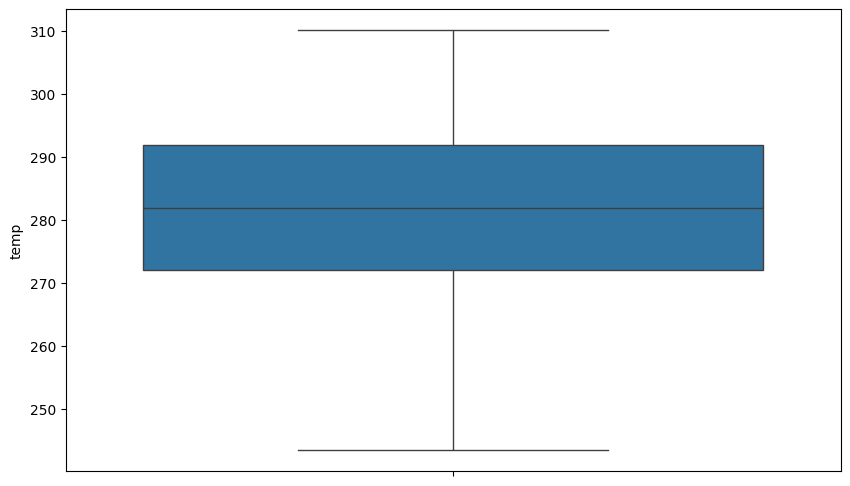

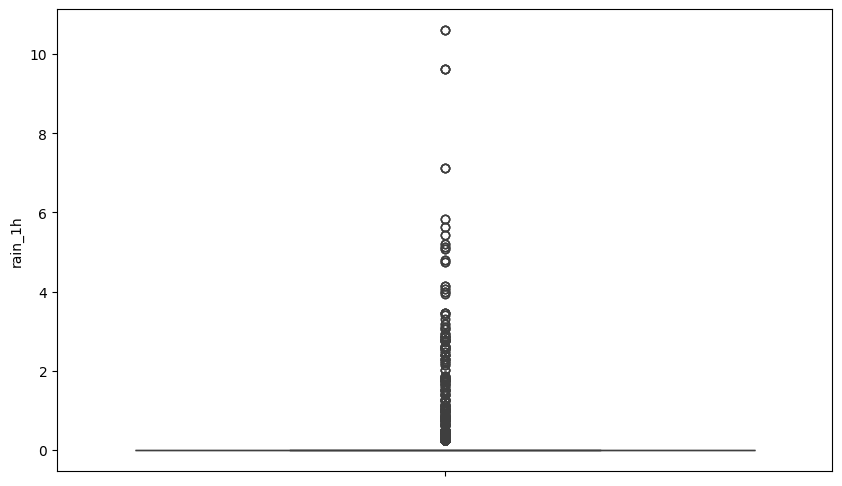

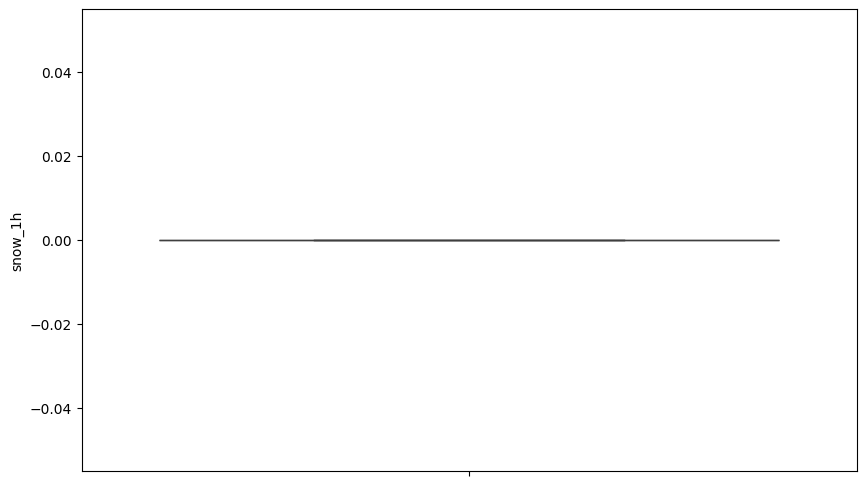

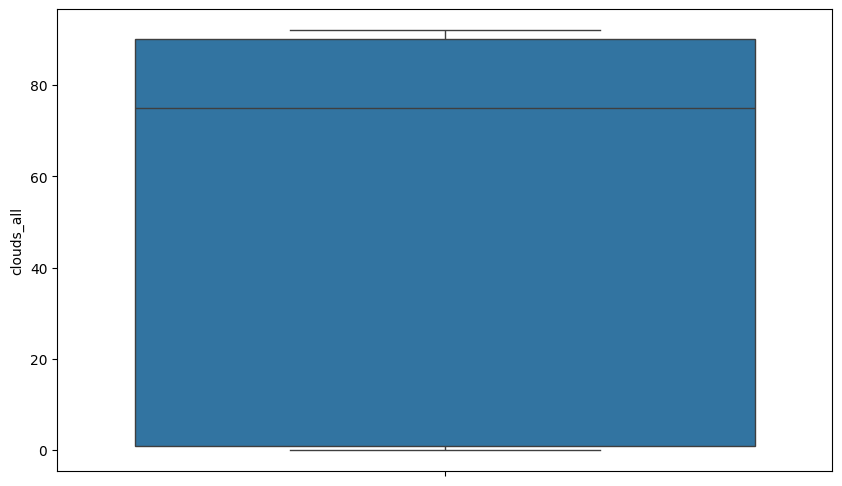

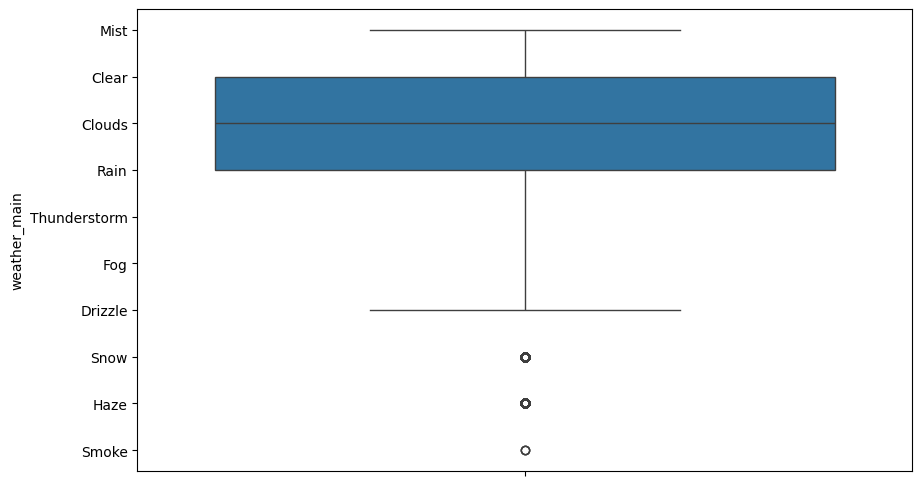

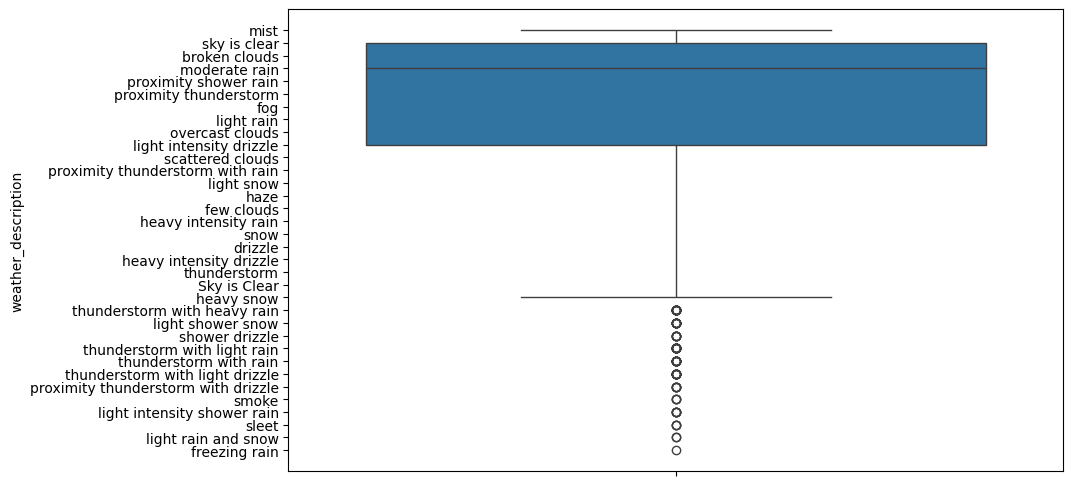

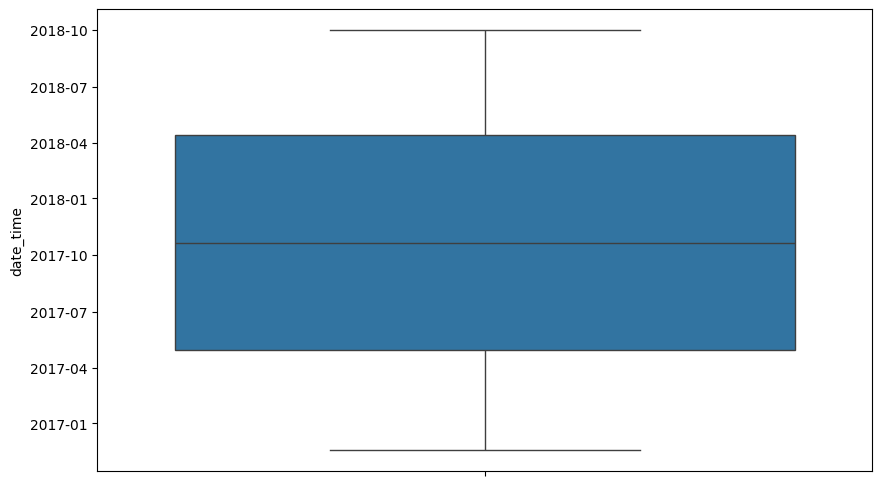

In [51]:
for column in df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(df[column])

In [52]:
df.sample(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
12845,614.0,278.91,0.00,0.0,1,Clear,sky is clear,2018-04-23 00:00:00
9062,367.0,295.65,0.00,0.0,40,Rain,heavy intensity rain,2018-06-18 01:00:00
8388,1146.0,268.48,0.00,0.0,1,Clear,sky is clear,2017-12-19 23:00:00
5908,281.0,269.72,0.00,0.0,90,Fog,fog,2017-12-11 01:00:00
5798,2924.0,287.60,0.81,0.0,90,Drizzle,drizzle,2018-09-20 05:00:00
11698,5927.0,299.87,0.00,0.0,40,Clouds,scattered clouds,2017-08-08 15:00:00
19115,858.0,279.48,0.00,0.0,90,Rain,moderate rain,2016-11-27 23:00:00
4155,2238.0,281.03,0.00,0.0,90,Mist,mist,2017-05-21 21:00:00
7517,2314.0,274.75,0.00,0.0,90,Snow,light snow,2017-03-17 23:00:00
193,868.0,285.93,0.00,0.0,75,Clouds,broken clouds,2017-08-04 04:00:00


In [53]:
num_df = df.select_dtypes(include=['number'])
cat_df = df.select_dtypes(include=['object'])

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [55]:
seasonal_decompose?

Signature:
seasonal_decompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
)
Docstring:
Seasonal decomposition using moving averages.

Parameters
----------
x : array_like
    Time series. If 2d, individual series are in columns. x must contain 2
    complete cycles.
model : {"additive", "multiplicative"}, optional
    Type of seasonal component. Abbreviations are accepted.
filt : array_like, optional
    The filter coefficients for filtering out the seasonal component.
    The concrete moving average method used in filtering is determined by
    two_sided.
period : int, optional
    Period of the series (e.g., 1 for annual, 4 for quarterly, etc). Must
    be used if x is not a pandas object or if the index of x does not have
    a frequency. Overrides default periodicity of x if x is a pandas
    object with a timeseries index.
two_sided : bool, optional
    The moving average method used in filtering.
    If True (default)

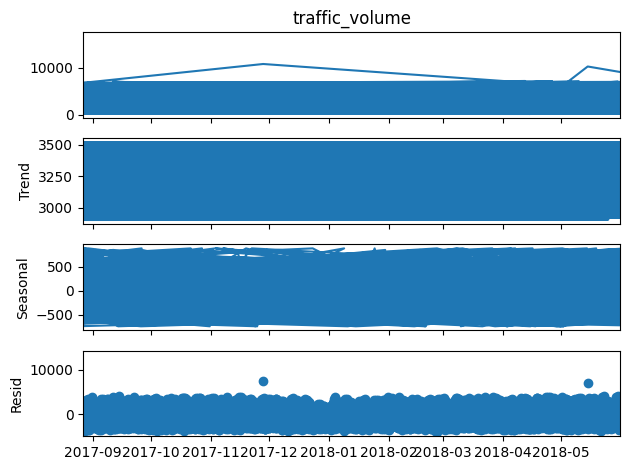

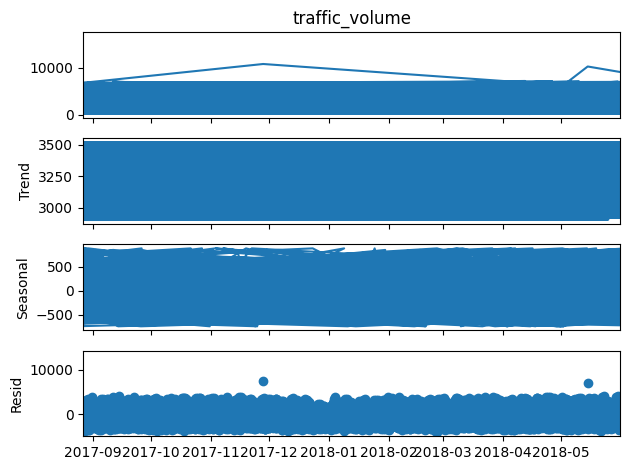

In [56]:
decompose  = seasonal_decompose(df.set_index('date_time')['traffic_volume'].dropna(), model='additive', period=365)
decompose.plot()

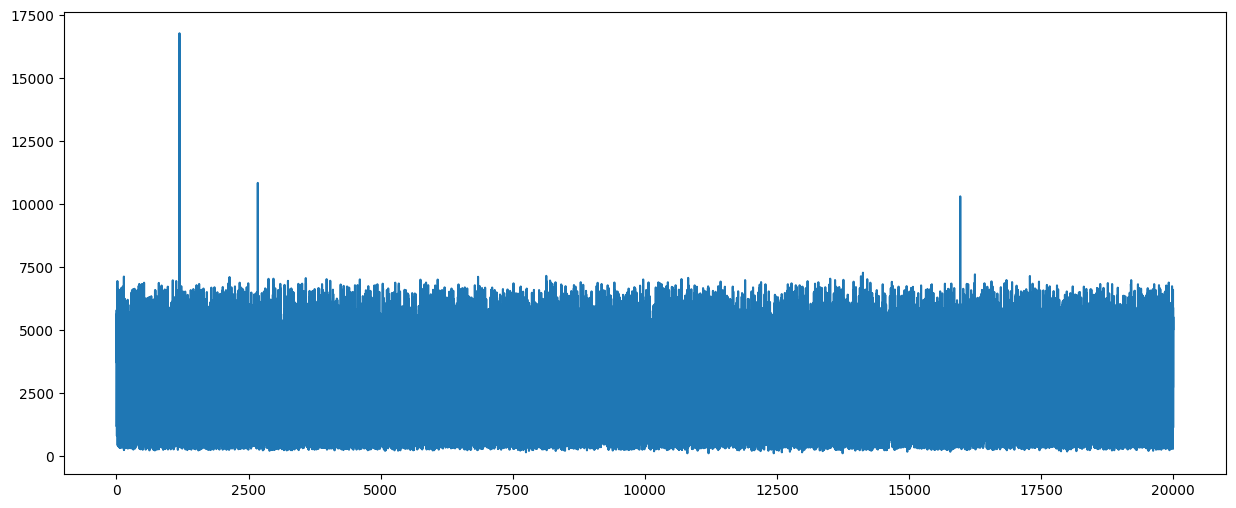

In [57]:
plt.figure(figsize=(15,6))
plt.plot(df['traffic_volume'])

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [58]:
df.isnull().sum()

traffic_volume         20
temp                    0
rain_1h                 0
snow_1h                 0
clouds_all              0
weather_main            0
weather_description     0
date_time               0
dtype: int64

In [59]:
df.fillna(method='bfill', inplace=True)
df.isnull().sum()

traffic_volume         0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
dtype: int64

In [60]:
df.duplicated().sum()

12

In [61]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [62]:
df['date_time'] = df['date_time']
df = df.set_index('date_time')

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [63]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['DayOfYear'] = df.index.dayofyear
df['diff_traffic_volume'] = df['traffic_volume'].diff()
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,DayOfWeek,Month,DayOfYear,diff_traffic_volume
date_time,,,,,,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist,NaN,6,8,239,NaN
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,1209.0,3,9,249,39.0
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,1248.0,4,8,237,3354.0
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,4602.0,3,11,313,-1764.0
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2838.0,3,11,313,2956.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,6601.0,2,6,157,-3878.0
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2723.0,2,10,298,3172.0
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,5895.0,2,3,87,-4763.0


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [64]:
df.dropna(inplace=True)
df.sort_index(inplace=True)
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,DayOfWeek,Month,DayOfYear,diff_traffic_volume
date_time,,,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,3403.0,4,11,323,1469.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog,3253.0,4,11,323,1619.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist,6038.0,4,11,323,-1166.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Snow,heavy snow,775.0,4,11,323,4299.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog,2453.0,4,11,323,2621.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds,4457.0,6,9,273,-914.0
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds,519.0,6,9,273,2262.0
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,6146.0,6,9,273,-3987.0


In [65]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
df_to_X_y = timeseries_dataset_from_array(df, df['traffic_volume'], sequence_length=24)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
# df_to_X_y.

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 10), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
df.drop(columns=df.select_dtypes(include=['object']),axis=1, inplace=True)

In [ ]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,prev_traffic_volume,DayOfWeek,Month,DayOfYear,diff_traffic_volume
date_time,,,,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,6038.0,4,11,323,-1166.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3403.0,4,11,323,1469.0
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,3253.0,4,11,323,1619.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,3071.0,4,11,323,2003.0
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,2453.0,4,11,323,2621.0
...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,4457.0,6,9,273,-914.0
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,519.0,6,9,273,2262.0
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,6146.0,6,9,273,-3987.0


In [ ]:
X = df.drop(columns='traffic_volume', axis=1)
y = df['traffic_volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=42)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train).reshape(-1,1)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[0.73019727],
       [0.        ],
       [0.        ],
       ...,
       [0.72727273],
       [0.66849315],
       [0.45041802]])

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
# GRU
model_gru = Sequential()

model_gru.add(GRU(50, return_sequences=True,input_shape=(df.shape[-1], 1)))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(25, return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(25, return_sequences=False))
model_gru.add(Dropout(0.2))

model_gru.add(Dense(1))

model_gru.compile(optimizer='adam', loss='mean_squared_error')

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [ ]:
early_stopping = EarlyStopping()
gru_history = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100, EarlyStopping = [early_stopping])

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [ ]:
model_lstm = Sequential()

model_lstm.add(LSTM(50, return_sequences=True ,input_shape=(df.shape[-1], 1)))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(25, return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(25, return_sequences=False))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(1, activation='linear'))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
early_stopping = EarlyStopping()
lstm_history = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100, EarlyStopping = [early_stopping])

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

- A1/ Used MinMax scaler, handled missing values with fillna (bfill) method because it is a time a series.
- A2/ Yes i did as requested and can be viewed above
- A3/ I chose LSTM and GRU because they are interestingly similar but slightly different, layers and models can viewed above, activation functions the default for linear activiation function.
- A4/ I used batch_size=32 and epochs=100 with earlystopping because i've used them alot before and they should to be reliable.
- A5/ Used MSE because it is the one to be used for time series and we want to see the differencing error between prediciton and actual data.
- A6/ I have used Earlystopping so it can tune itself with an upper limit of 100 epochs.
- A7/ thing's happened with my code and i wasn't able to run it.
- A8/ I implement these times series more and learn it better.